<a href="https://colab.research.google.com/github/ruoxinli94/Python/blob/master/MovieRecALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType, FloatType
from mpl_toolkits.mplot3d import axes3d

     |████████████████████████████████| 204.7MB 61kB/s 
     |████████████████████████████████| 204kB 43.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=4744e23e94c88b16ecc653ad264b8083a51003125f163c7b52390e3254ad8dbb
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Data/ml-latest-small"

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
#create dataframe
movies_df = spark.read.load("/content/drive/My Drive/Data/ml-latest-small/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("/content/drive/My Drive/Data/ml-latest-small/ratings.csv", format='csv', header = True)
links_df = spark.read.load("/content/drive/My Drive/Data/ml-latest-small/links.csv", format='csv', header = True)
tags_df = spark.read.load("/content/drive/My Drive/Data/ml-latest-small/tags.csv", format='csv', header = True)

In [ ]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [ ]:
# create RDD 
textFile = sc.textFile("/content/drive/My Drive/Data/ml-latest-small/ratings.csv")
type(textFile)

pyspark.rdd.RDD

# Info of Users

In [ ]:
ratings_df.select('userID').distinct().count()

610

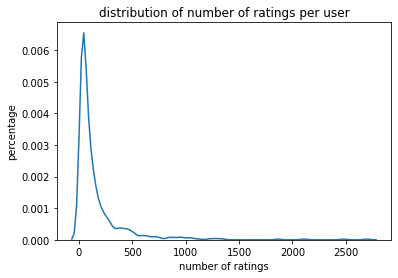

In [ ]:
users_result = ratings_df.groupBy('userID')\
.count().orderBy('count', ascending = False)
fig = plt.figure()
tmp = sns.distplot(users_result.toPandas()['count'], hist = False)
plt.ylabel('percentage')
plt.xlabel('number of ratings')
tmp.set_title('distribution of number of ratings per user')
display(tmp)


In [ ]:
users_result.toPandas().head()

,userID,count
0,414,2698
1,599,2478
2,474,2108
3,448,1864
4,274,1346


# Info of Movies

In [ ]:
movies_df.select('movieID').distinct().count()

9742

In [ ]:
# movie that has not been rated 
movies = ratings_df.select('movieID').distinct()
moviearray = [int(row.movieID) for row in movies.collect()]
# is in need to pass in an array
movienotrate = movies_df[~movies_df['movieID'].isin(moviearray)].orderBy('title')
movienotrate.select('title','genres').toPandas()

,title,genres
0,"Browning Version, The (1951)",Drama
1,Call Northside 777 (1948),Crime|Drama|Film-Noir
2,Chalet Girl (2011),Comedy|Romance
3,"Chosen, The (1981)",Drama
4,"Color of Paradise, The (Rang-e khoda) (1999)",Drama
5,For All Mankind (1989),Documentary
6,I Know Where I'm Going! (1945),Drama|Romance|War
7,In the Realms of the Unreal (2004),Animation|Documentary
8,"Innocents, The (1961)",Drama|Horror|Thriller
9,Mutiny on the Bounty (1962),Adventure|Drama|Romance


In [ ]:
ratings_df.select('movieID').distinct().count()

9724

In [ ]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



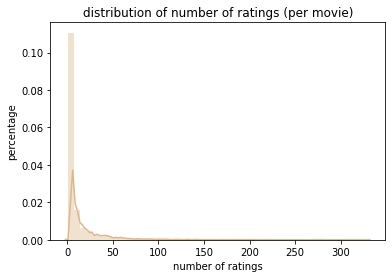

In [ ]:
movie_result = ratings_df.groupBy("movieID").count()\
.orderBy('count', ascending = False)

fig = plt.figure()
tmp = sns.distplot(movie_result.toPandas()['count'], color='burlywood', hist=True)
plt.ylabel('percentage')
plt.xlabel('number of ratings')
tmp.set_title('distribution of number of ratings (per movie)')
display(tmp)

In [ ]:
movie_result.toPandas().describe()

,count
count,9724.000000
mean,10.369807
std,22.401005
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,329.000000


In [ ]:
movies_genre_temp = movies_df.where('genres is not null')\
.select('title', f.explode(f.split('genres','\|'))\
        
        .alias('genres'))
movies_genre_temp.show()

+--------------------+---------+
|               title|   genres|
+--------------------+---------+
|    Toy Story (1995)|Adventure|
|    Toy Story (1995)|Animation|
|    Toy Story (1995)| Children|
|    Toy Story (1995)|   Comedy|
|    Toy Story (1995)|  Fantasy|
|      Jumanji (1995)|Adventure|
|      Jumanji (1995)| Children|
|      Jumanji (1995)|  Fantasy|
|Grumpier Old Men ...|   Comedy|
|Grumpier Old Men ...|  Romance|
|Waiting to Exhale...|   Comedy|
|Waiting to Exhale...|    Drama|
|Waiting to Exhale...|  Romance|
|Father of the Bri...|   Comedy|
|         Heat (1995)|   Action|
|         Heat (1995)|    Crime|
|         Heat (1995)| Thriller|
|      Sabrina (1995)|   Comedy|
|      Sabrina (1995)|  Romance|
| Tom and Huck (1995)|Adventure|
+--------------------+---------+
only showing top 20 rows



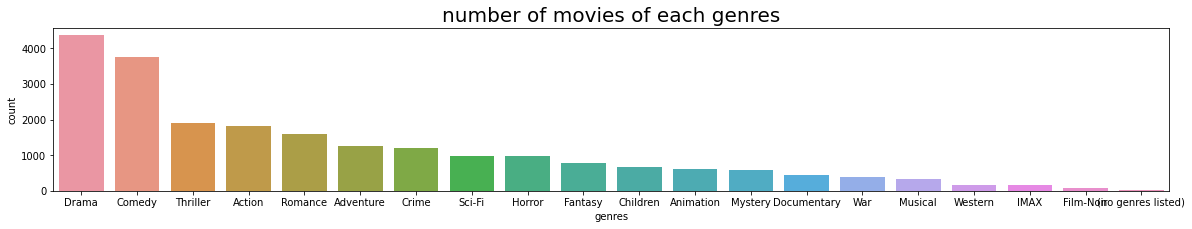

In [ ]:
movies_genres = movies_genre_temp.groupby('genres').count()\
.orderBy('count', ascending = False)\
.toPandas()

plt.figure(figsize=(20,3))
tmp = sns.barplot(x='genres', y = 'count', data=movies_genres)
tmp.set_title('number of movies of each genres', fontsize = 20)
display(tmp)

In [ ]:
moviegenrescount = movies_df.select('title', f.explode(f.split('genres','\|')).alias('genres'))\
.groupBy('genres').count().orderBy('count', ascending = False)
moviegenrescount.show()

+------------------+-----+
|            genres|count|
+------------------+-----+
|             Drama| 4361|
|            Comedy| 3756|
|          Thriller| 1894|
|            Action| 1828|
|           Romance| 1596|
|         Adventure| 1263|
|             Crime| 1199|
|            Sci-Fi|  980|
|            Horror|  978|
|           Fantasy|  779|
|          Children|  664|
|         Animation|  611|
|           Mystery|  573|
|       Documentary|  440|
|               War|  382|
|           Musical|  334|
|           Western|  167|
|              IMAX|  158|
|         Film-Noir|   87|
|(no genres listed)|   34|
+------------------+-----+



In [ ]:
movie_genre_title = movies_genre_temp.groupBy('genres')\
.agg(f.collect_list('title')\
     .alias('titles')).toPandas()
movie_genre_title.head()

,genres,titles
0,Crime,"[Heat (1995), Casino (1995), Money Train (1995..."
1,Romance,"[Grumpier Old Men (1995), Waiting to Exhale (1..."
2,Thriller,"[Heat (1995), GoldenEye (1995), Money Train (1..."
3,Adventure,"[Toy Story (1995), Jumanji (1995), Tom and Huc..."
4,Drama,"[Waiting to Exhale (1995), American President,..."


# Info of Ratings

In [ ]:
rating_result = ratings_df.groupBy('rating').count()\
.withColumn('rating', ratings_df.rating.cast('float'))\
.orderBy('rating', ascending = False)\
.toPandas()

In [ ]:
rating_result.head()

,rating,count
0,5.0,13211
1,4.5,8551
2,4.0,26818
3,3.5,13136
4,3.0,20047


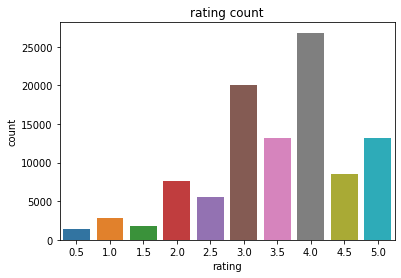

In [ ]:
fig = plt.figure()
tmp = sns.barplot(x='rating', y='count', data = rating_result)
tmp.set_title('rating count')
display(tmp)

In [ ]:
# sparsity
tmp = ratings_df.count()
1-tmp/9724/610

0.9830003169443864

# ALS model

In [ ]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [ ]:
ratings = ratings_df.drop('timestamp')

In [ ]:
ratings = ratings.withColumn('userID', ratings['userID'].cast(IntegerType()))\
.withColumn('movieID',ratings['movieID'].cast(IntegerType()))\
.withColumn('rating', ratings['rating'].cast(FloatType()))


In [ ]:
ratings.show()

+------+-------+------+
|userID|movieID|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [ ]:
(training, testing) = ratings.randomSplit([0.8,0.2])

In [ ]:
als = ALS(maxIter=5, rank=10, regParam=0.01, userCol='userID', itemCol='movieID',ratingCol='rating',
          coldStartStrategy = 'drop')
paramgrid = ParamGridBuilder().addGrid(als.maxIter,[5,10])\
.addGrid(als.rank, [2,5,10])\
.addGrid(als.regParam, [0.01, 0.1, 0.5]).build()
rmse_evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',predictionCol='prediction')
cv = CrossValidator(estimator=als, estimatorParamMaps=paramgrid,
                    evaluator = rmse_evaluator,
                    numFolds = 5, collectSubModels = True, seed=1)

In [ ]:
#cmodel = cv.fit(training)

In [ ]:
'''
best_model = cmodel.bestModel
print("rank",best_model.rank," ,maxiter", best_model._java_obj.parent().getMaxIter(),
      " ,regparam", best_model._java_obj.parent().getRegParam())

bstrank = best_model.rank
bstmaxiter = best_model._java_obj.parent().getMaxIter()
bstregparam = best_model._java_obj.parent().getRegParam()
'''
bstrank = 2
bstmaxiter = 5
bstregparam = 0.1
best_model = ALS(maxIter=bstmaxiter, rank=bstrank, regParam=bstregparam, userCol='userID', itemCol='movieID',ratingCol='rating',
          coldStartStrategy = 'drop')
best_model = best_model.fit(training)

In [ ]:
predictions = best_model.transform(testing)
rmse = rmse_evaluator.evaluate(predictions)
print('rmse=',rmse)

rmse= 0.8771178201544589


In [ ]:
bst_als = ALS(maxIter=bstmaxiter, rank=bstrank, regParam=bstregparam, userCol='userID', itemCol='movieID',ratingCol='rating',
          coldStartStrategy = 'drop')
bstmdl = bst_als.fit(ratings)
alldata = bstmdl.transform(ratings)
rmse_all=rmse_evaluator.evaluate(alldata)
print(rmse_all)

0.7488083439280085


In [ ]:
alldata = alldata.withColumn('rounded_prediction', f.round(f.col('prediction')*2)/2)
alldata_tmp = alldata.toPandas()
alldata_tmp.head()

,userID,movieID,rating,prediction,rounded_prediction
0,191,148,5.0,4.942147,5.0
1,133,471,4.0,2.842574,3.0
2,597,471,2.0,3.966779,4.0
3,385,471,4.0,3.306822,3.5
4,436,471,3.0,3.273357,3.5


In [ ]:
userRecs = bstmdl.recommendForAllUsers(10)
movieRecs = bstmdl.recommendForAllItems(10)

In [ ]:
alldata.registerTempTable('alldata')

In [ ]:
alldata.join(movies_df, on=['movieID'], how='inner').show()

+-------+------+------+----------+------------------+--------------------+------+
|movieID|userID|rating|prediction|rounded_prediction|               title|genres|
+-------+------+------+----------+------------------+--------------------+------+
|    148|   191|   5.0| 4.9421473|               5.0|Awfully Big Adven...| Drama|
|    471|   133|   4.0| 2.8425736|               3.0|Hudsucker Proxy, ...|Comedy|
|    471|   597|   2.0| 3.9667785|               4.0|Hudsucker Proxy, ...|Comedy|
|    471|   385|   4.0| 3.3068216|               3.5|Hudsucker Proxy, ...|Comedy|
|    471|   436|   3.0|  3.273357|               3.5|Hudsucker Proxy, ...|Comedy|
|    471|   602|   4.0|  3.296532|               3.5|Hudsucker Proxy, ...|Comedy|
|    471|    91|   1.0| 3.3379266|               3.5|Hudsucker Proxy, ...|Comedy|
|    471|   409|   3.0|  3.793216|               4.0|Hudsucker Proxy, ...|Comedy|
|    471|   372|   3.0| 3.2154036|               3.0|Hudsucker Proxy, ...|Comedy|
|    471|   599|

# recommend movies to user 575 and 232

In [ ]:
users = [575,232]
alldata[alldata['userID'].isin(users)].join(movies_df, on=['movieID'], how='inner').show()

+-------+------+------+----------+------------------+--------------------+--------------------+
|movieID|userID|rating|prediction|rounded_prediction|               title|              genres|
+-------+------+------+----------+------------------+--------------------+--------------------+
|   1580|   232|   3.5| 3.3425965|               3.5|Men in Black (a.k...|Action|Comedy|Sci-Fi|
|   3175|   232|   2.5| 3.3835464|               3.5| Galaxy Quest (1999)|Adventure|Comedy|...|
|  36525|   232|   3.0| 2.7616892|               3.0|Just Like Heaven ...|Comedy|Fantasy|Ro...|
|  44022|   232|   3.0| 3.2170224|               3.0|Ice Age 2: The Me...|Adventure|Animati...|
|  68135|   232|   4.0| 3.3538826|               3.5|     17 Again (2009)|        Comedy|Drama|
|    858|   232|   4.0| 3.8568704|               4.0|Godfather, The (1...|         Crime|Drama|
|   1721|   232|   4.5| 3.2847073|               3.5|      Titanic (1997)|       Drama|Romance|
|   2580|   575|   4.0|  4.118822|      

# similar movies for movie 463 and 471


In [ ]:
tmp_compare = best_model.itemFactors
movies = [463,471]
compare = tmp_compare[tmp_compare['id'].isin(movies)].select('id','features').withColumnRenamed('id','id1').withColumnRenamed('features','f1')\
.crossJoin(tmp_compare.select('id','features').where('id!=471').withColumnRenamed('id','id2').withColumnRenamed('features','f2'))
compare.show()

+---+--------------------+---+--------------------+
|id1|                  f1|id2|                  f2|
+---+--------------------+---+--------------------+
|471|[0.6199339, -1.89...| 10|[-0.078373104, -1...|
|471|[0.6199339, -1.89...| 20|[-0.35833076, -1....|
|471|[0.6199339, -1.89...| 30|[2.548732, -1.097...|
|471|[0.6199339, -1.89...| 40|[1.5492972, -1.58...|
|471|[0.6199339, -1.89...| 50|[0.33885282, -2.2...|
|471|[0.6199339, -1.89...| 60|[-0.41266137, -1....|
|471|[0.6199339, -1.89...| 70|[0.082179315, -1....|
|471|[0.6199339, -1.89...| 80|[0.896915, -1.901...|
|471|[0.6199339, -1.89...|100|[0.044483535, -1....|
|471|[0.6199339, -1.89...|110|[0.008192444, -2....|
|471|[0.6199339, -1.89...|140|[0.14285693, -1.6...|
|471|[0.6199339, -1.89...|150|[0.115892924, -1....|
|471|[0.6199339, -1.89...|160|[-0.7825554, -1.4...|
|471|[0.6199339, -1.89...|170|[-0.19962782, -1....|
|471|[0.6199339, -1.89...|180|[0.44158512, -1.8...|
|471|[0.6199339, -1.89...|190|[1.4910133, -1.31...|
|471|[0.6199

In [ ]:
# cosin similarity 
def cos_sim(a,b):
  return float(np.dot(a,b)/np.linalg.norm(a)*np.linalg.norm(b))
cosine = spark.udf.register('cos_sim',cos_sim, FloatType())

In [ ]:
movies_df[movies_df['movieID'].isin(movies)].select('title').show()

[463, 471]
+--------------------+
|               title|
+--------------------+
|Hudsucker Proxy, ...|
+--------------------+



In [ ]:
# movie that similar to 471 Hudsucker Proxy, movie 463 does not exist
result = compare.withColumn('similarity', cosine(f.col('f1'), f.col('f2')))\
.where('similarity > 10.0').orderBy('similarity', ascending=False)
result = result.join(movies_df , movies_df['movieID'] == result['id2'], 'left').orderBy('similarity', ascending = False)
result.show()

+---+--------------------+-----+--------------------+----------+-------+--------------------+--------------------+
|id1|                  f1|  id2|                  f2|similarity|movieId|               title|              genres|
+---+--------------------+-----+--------------------+----------+-------+--------------------+--------------------+
|471|[0.6199339, -1.89...| 5746|[0.9270549, -4.23...|  18.69305|   5746|Galaxy of Terror ...|Action|Horror|Mys...|
|471|[0.6199339, -1.89...| 5764|[0.8343494, -3.81...| 15.141371|   5764|       Looker (1981)|Drama|Horror|Sci-...|
|471|[0.6199339, -1.89...| 7899|[0.8343494, -3.81...| 15.141371|   7899|Master of the Fly...|              Action|
|471|[0.6199339, -1.89...| 8477|[0.15843113, -3.8...| 14.453099|   8477|    Jetée, La (1962)|      Romance|Sci-Fi|
|471|[0.6199339, -1.89...|40491|[0.15843113, -3.8...| 14.453099|  40491|Match Factory Gir...|        Comedy|Drama|
|471|[0.6199339, -1.89...|70946|[3.7429311, -1.85...| 12.209805|  70946|      Tr